1. Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13. That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have already quit, then company headcount on 2012/03/02 for company 1 would be 1000. You should create a table with 3 columns: day, employee_headcount, company_id.
2. What are the main factors that drive employee churn? Do they make sense? Explain your findings.
3. If you could add to this data set just one variable that could help explain employee churn, what would that be?

In [1]:
import pandas as pd
from pandas_profiling import ProfileReport

import numpy as np

from datetime import datetime

import matplotlib.pyplot as plt

In [79]:
data = pd.read_csv("Data/03_Employee_Retention/employee_retention.csv")

In [15]:
profile = ProfileReport(data, title='Employee Retention', explorative=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [4]:
data.shape

(24702, 7)

In [5]:
for column in data.columns:
    print(column, len(set(data[column])))

employee_id 24702
company_id 12
dept 6
seniority 31
salary 367
join_date 995
quit_date 665


In [3]:
company_ids = list(set(data['company_id']))
print(company_ids)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [4]:
start_date = '2011-01-24'
end_date = '2015-12-13'

dates = pd.date_range(start=start_date, end=end_date, freq='D')
date_len = len(dates)

print(date_len)

1785


In [5]:
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

In [37]:
# Time Complexity: O(n)

company2date = {i: [0] * date_len for i in company_ids}

join_dates = list(zip(data.join_date, data.company_id))

quit_dates = list(zip(data.quit_date, data.company_id))
quit_dates = [(date, id) for date, id in quit_dates if not pd.isna(date)]

for join_date, company_id in join_dates:
    i = days_between(join_date, start_date)    
    company2date[company_id][i] += 1
        

for quit_date, company_id in quit_dates:
    i = days_between(quit_date, start_date)
    company2date[company_id][i] -= 1
    
for company_id in company_ids:
    for i in range(1, date_len):
        company2date[company_id][i] += company2date[company_id][i-1]

In [38]:
employee_hc_df = pd.DataFrame.from_dict(company2date, orient='index', columns=dates).T
employee_hc_df.index.names = ['day']
employee_hc_df.columns = [f"company_id-{i}" for i in company_ids]
employee_hc_df = employee_hc_df.reset_index()

employee_hc_df = pd.wide_to_long(employee_hc_df, stubnames="company_id", i="day", j="employee_headcount", sep='-').reset_index()
employee_hc_df.rename(columns={"employee_headcount": "company_id", "company_id": "employee_headcount"}, inplace=True)
employee_hc_df

,day,company_id,employee_headcount
0,2011-01-24,1,25
1,2011-01-25,1,27
2,2011-01-26,1,29
3,2011-01-27,1,29
4,2011-01-28,1,29
...,...,...,...
21415,2015-12-09,12,12
21416,2015-12-10,12,12
21417,2015-12-11,12,12
21418,2015-12-12,12,12


In [147]:
# Time Complexity: O(n^2)

company2date_v2 = {i: [0] * date_len for i in company_ids}

for row in data.itertuples():
    
    start_i = days_between(row.join_date, start_date)
    
    if pd.isnull(row.quit_date):
        end_i = date_len
    else:
        end_i = days_between(row.quit_date, start_date)
        
    company2date_v2[row.company_id][start_i:end_i] = [e + 1 for e in company2date_v2[row.company_id][start_i:end_i]]

# 2. What are the main factors that drive employee churn? Do they make sense? Explain your findings.

date? season? company id (company size)? seniority? salary? dept?

In [84]:
# Append some columns 

data['churn'] = np.where(data['quit_date'].isnull(), 0, 1)

data["join_date"] = pd.to_datetime(data["join_date"])
data["quit_date"] = pd.to_datetime(data["quit_date"])

data['duration'] = (data['quit_date'].fillna(pd.to_datetime('2015-12-13')) - data['join_date']).apply(lambda x: x.days)

data["join_month"] = 'm' + data["join_date"].dt.month.astype(str)
data["join_quarter"] = 'q' + data["join_date"].dt.quarter.astype(str)

In [85]:
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,churn,duration,join_month,join_quarter
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,1,585,m3,q1
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,1,340,m4,q2
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,0,426,m10,q4
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1,389,m5,q2
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1,1040,m10,q4


## Outliers

In [18]:
# Only two columns, "seniority" and "salary", are continuous variables

data[["seniority", "salary"]].describe()

,seniority,salary
count,24702.000000,24702.000000
mean,14.127803,138183.345478
std,8.089520,76058.184573
min,1.000000,17000.000000
25%,7.000000,79000.000000
50%,14.000000,123000.000000
75%,21.000000,187000.000000
max,99.000000,408000.000000


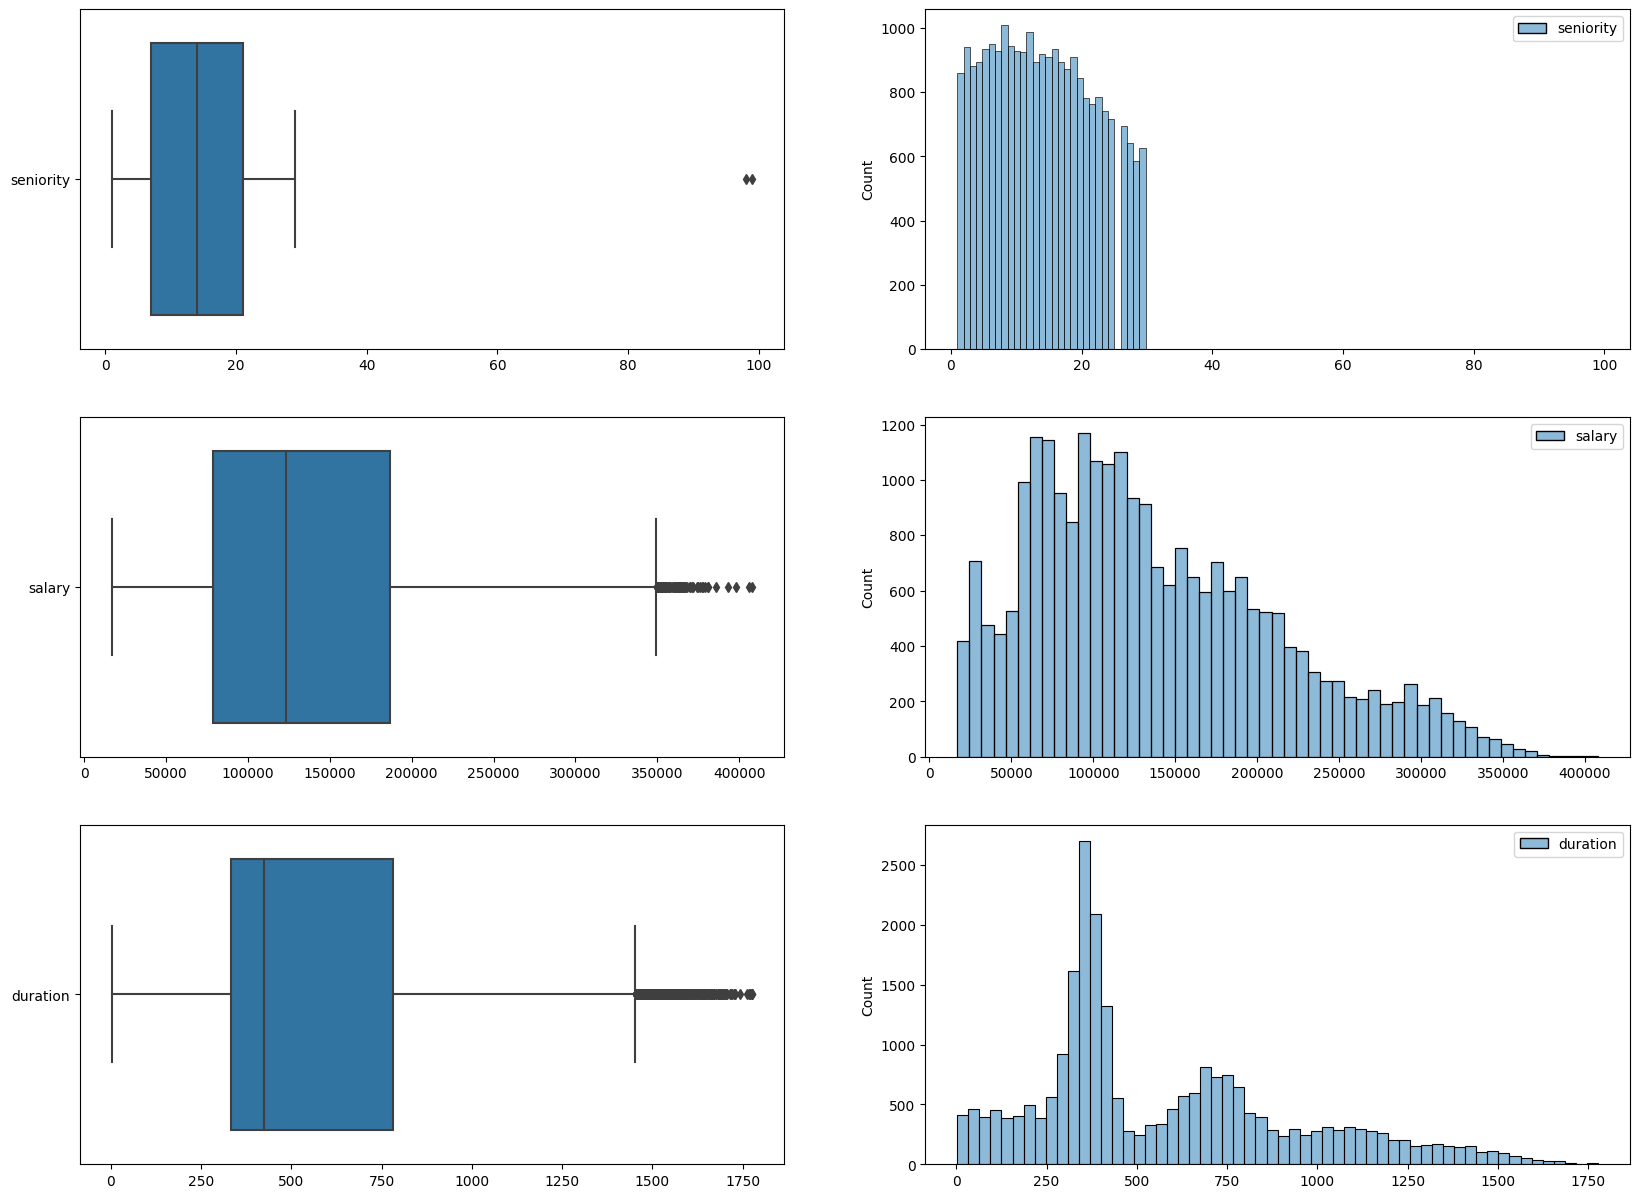

In [88]:
import seaborn as sns

fig, axes = plt.subplots(3, 2, figsize=(20, 15))

sns.boxplot(data=data[["seniority"]], ax=axes[0, 0], orient="h")
sns.histplot(data=data[["seniority"]], ax=axes[0, 1])

sns.boxplot(data=data[["salary"]], ax=axes[1, 0], orient="h")
sns.histplot(data=data[["salary"]], ax=axes[1, 1])

sns.boxplot(data=data[["duration"]], ax=axes[2, 0], orient="h")
sns.histplot(data=data[["duration"]], ax=axes[2, 1])


plt.show()

In [43]:
data[data["seniority"] > 60]

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,churn,join_month,join_quarter
24700,97289.0,10,engineer,98,266000.0,2011-12-13,2015-01-09,1,12,4
24701,604052.0,1,marketing,99,185000.0,2011-07-26,2013-12-06,1,7,3


- seniority
    - Outliers: seniority = 98, 99

In [44]:
# remove outliers

data = data[data["seniority"] < 60]

In [45]:
data[data["seniority"] > 60]

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,churn,join_month,join_quarter


## Churn or not

In [90]:
def plot_conversion_rate_categorical(df, target):
    
    custom_params = {"axes.spines.top": False, "font.size": 16}
    sns.set_theme(style="ticks", palette="Set2", font_scale=2, rc=custom_params)

    # calculate the conversion rate and the number of users for each target of interest
    total = df.groupby(target)["churn"].count().reset_index()
    group = df[[target, "churn"]].groupby(target).mean().reset_index()
    order_list = group[target]
    
    data[target] = data[target].astype("category")
    group[target] = group[target].astype("category")

    fig, g1 = plt.subplots(figsize=(20, 6))
    g2 = g1.twinx()

    # barplot
    sns.countplot(df, x=target, hue="churn", order=order_list, ax=g1)
    g1.set_yscale("log")

    # lineplot: to show conversion rate
    g2.plot(group[target], group["churn"], color="dimgrey", marker='o', linestyle='dashed',
         linewidth=2, markersize=8)

    # annotation
    for i in range(group.shape[0]):

        x = group.iloc[i][target]
        y = group.iloc[i]["churn"]
        label = f"{y*100:.2f}%"

        plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha='center', color="dimgrey")
        
    # add the number of users for each target of interest to x labels
    labels = [item.get_text() for item in g1.get_xticklabels()]

#     if target == "new_user":
#         labels = [int(label) for label in labels]
        
#     labels = [f"{label} \n {total[total[target] == label]['churn'].values[0]:,}" for label in labels]
    g1.set_xticklabels(labels)
    
#     fig.text(0.06, 0, 'Note: Numbers under labels are the total number for each label', ha='left', fontsize=20)
    
    plt.title(f"Churn rate by {target}", fontsize=25, pad=40)
    plt.tight_layout()
    plt.show()
    
    
def plot_conversion_rate_continuous(df, target):
    
    custom_params = {"axes.spines.top": False, "axes.spines.right": False, "font.size": 16}
    sns.set_theme(style="ticks", palette="Set2", font_scale=2, rc=custom_params)

    group = df[[target, "churn"]].groupby(target).mean().reset_index()

    fig, ax = plt.subplots(figsize=(20, 5))
    ax.plot(group[target], group["churn"], linewidth=2)

    ax.set_xlabel(target)
    ax.set_ylabel("Churn rate")
    
    plt.title(f"Churn rate by {target}", fontsize=25, pad=40)
    plt.show()

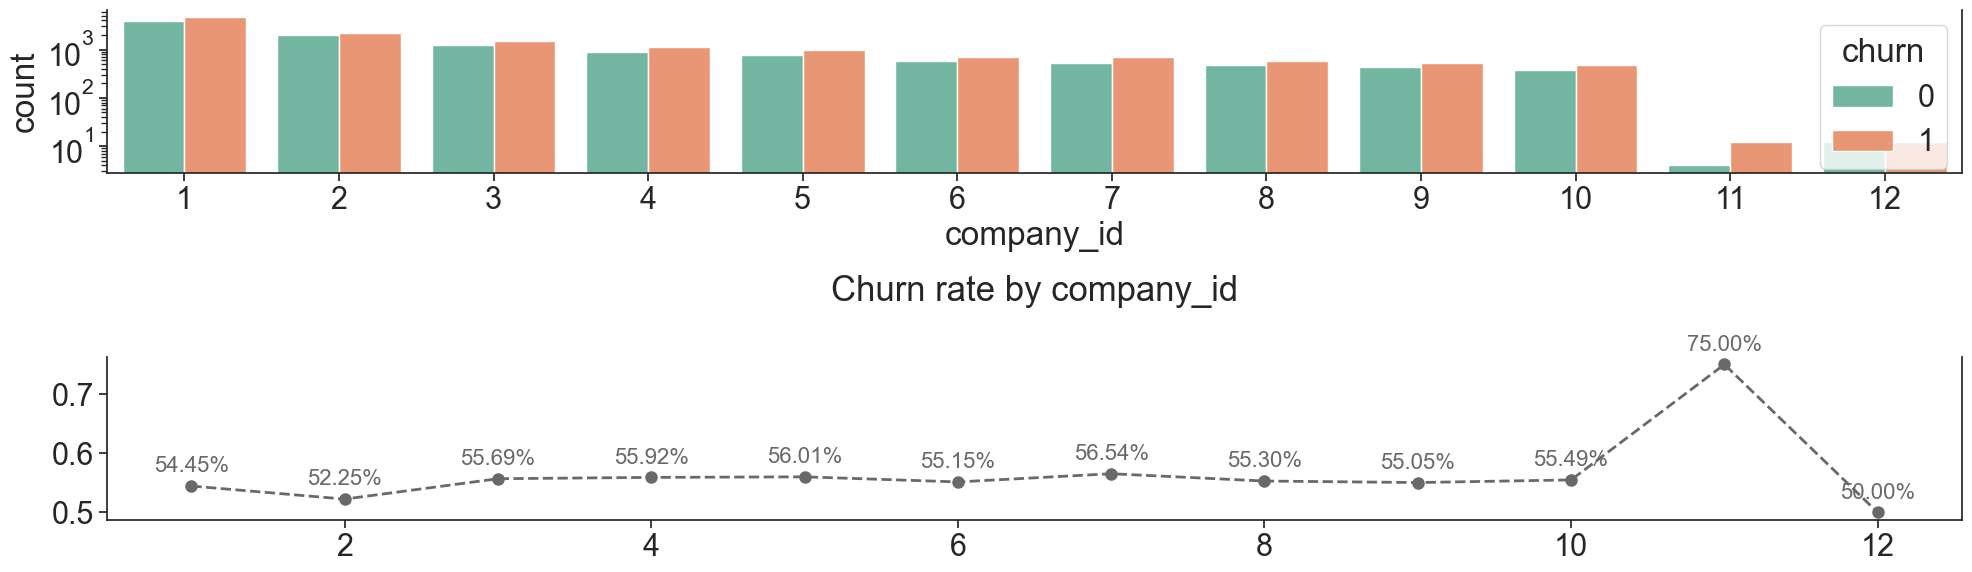

In [106]:
plot_conversion_rate_categorical(data, "company_id")

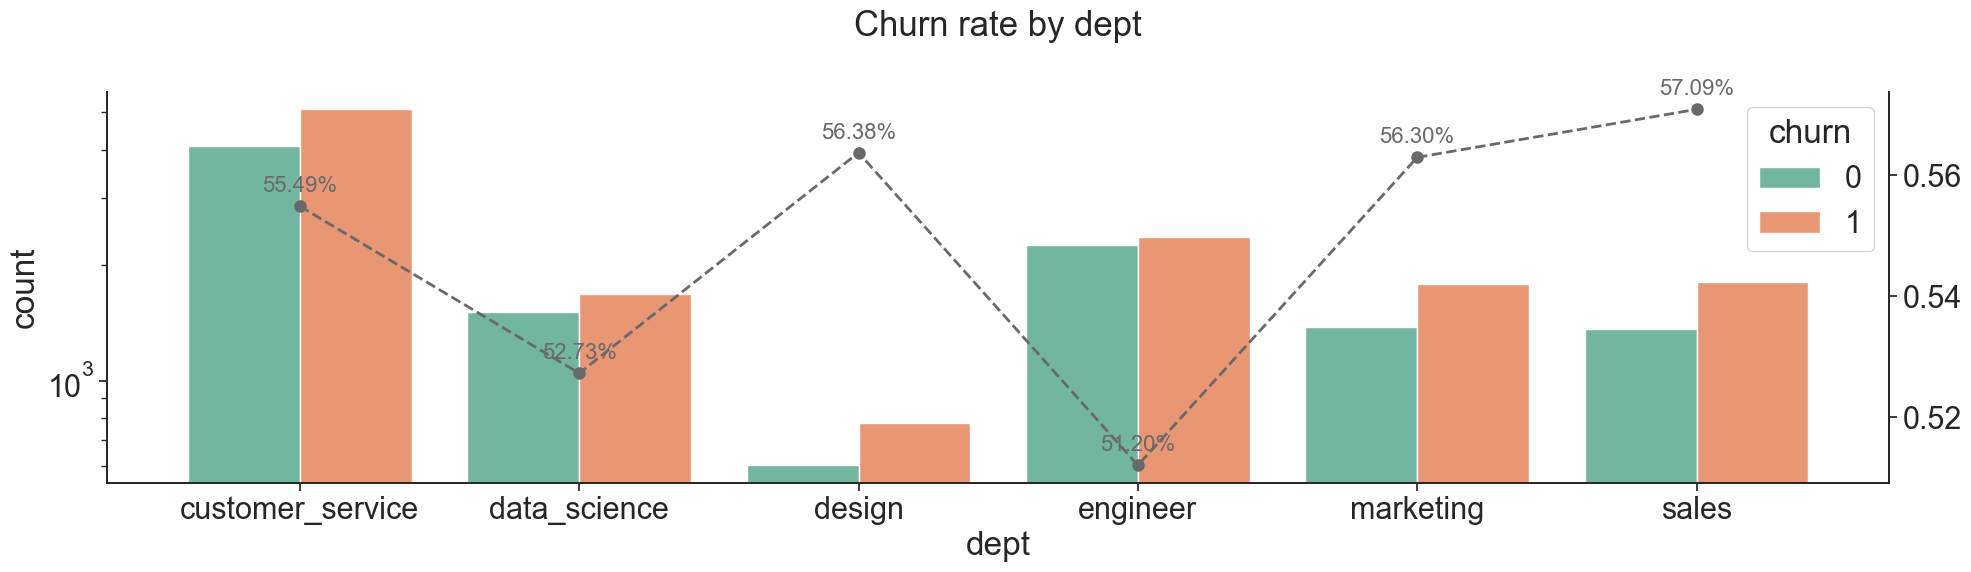

In [109]:
plot_conversion_rate_categorical(data, "dept")

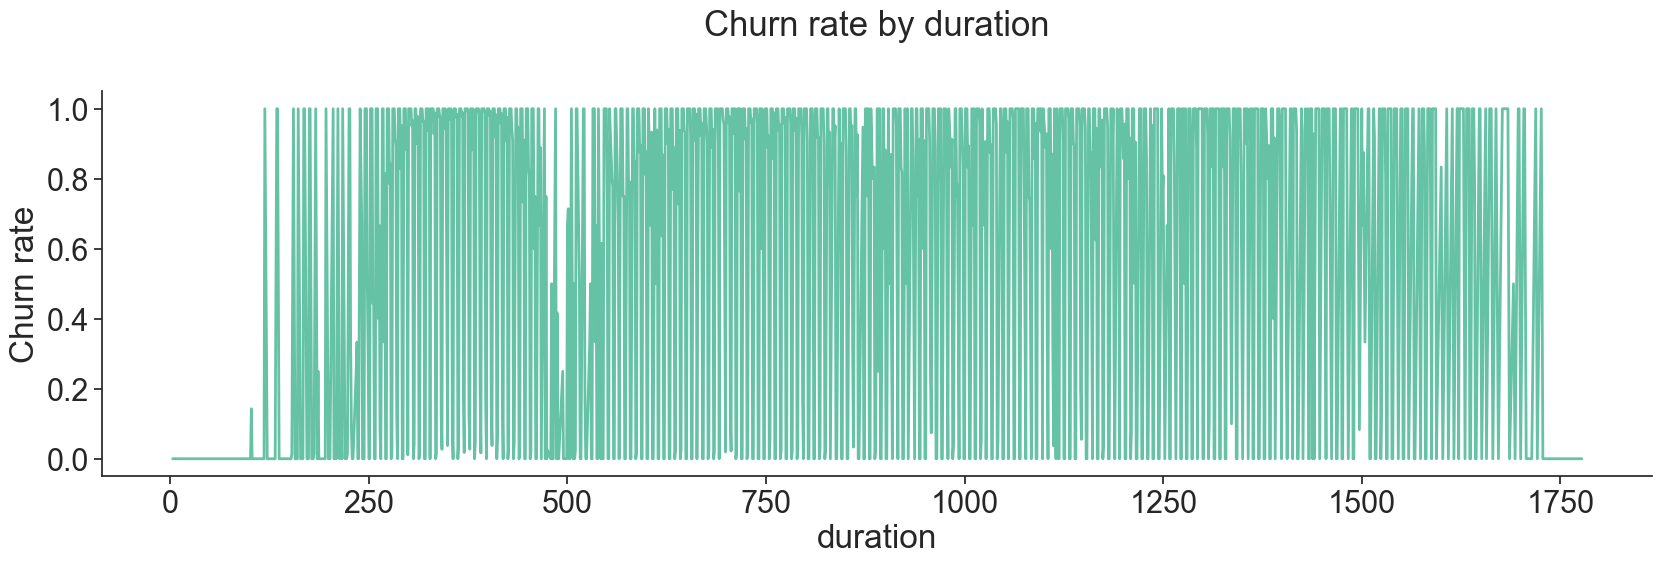

In [91]:
plot_conversion_rate_continuous(data, "duration")

/var/folders/qk/znpvqtsn3jl5jf9q97fqz2cc0000gp/T/ipykernel_33615/1595272399.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['duration']/365)


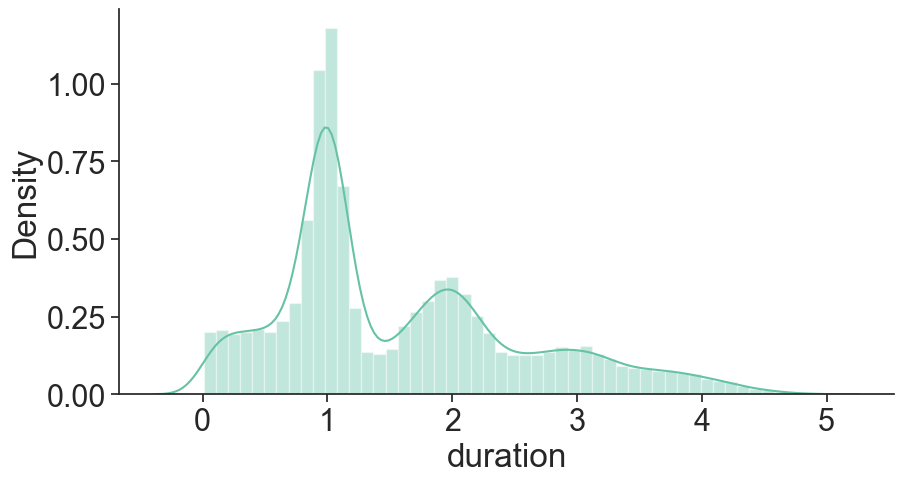

In [93]:
plt.figure(figsize=(10, 5))

sns.distplot(data['duration']/365)

plt.show()

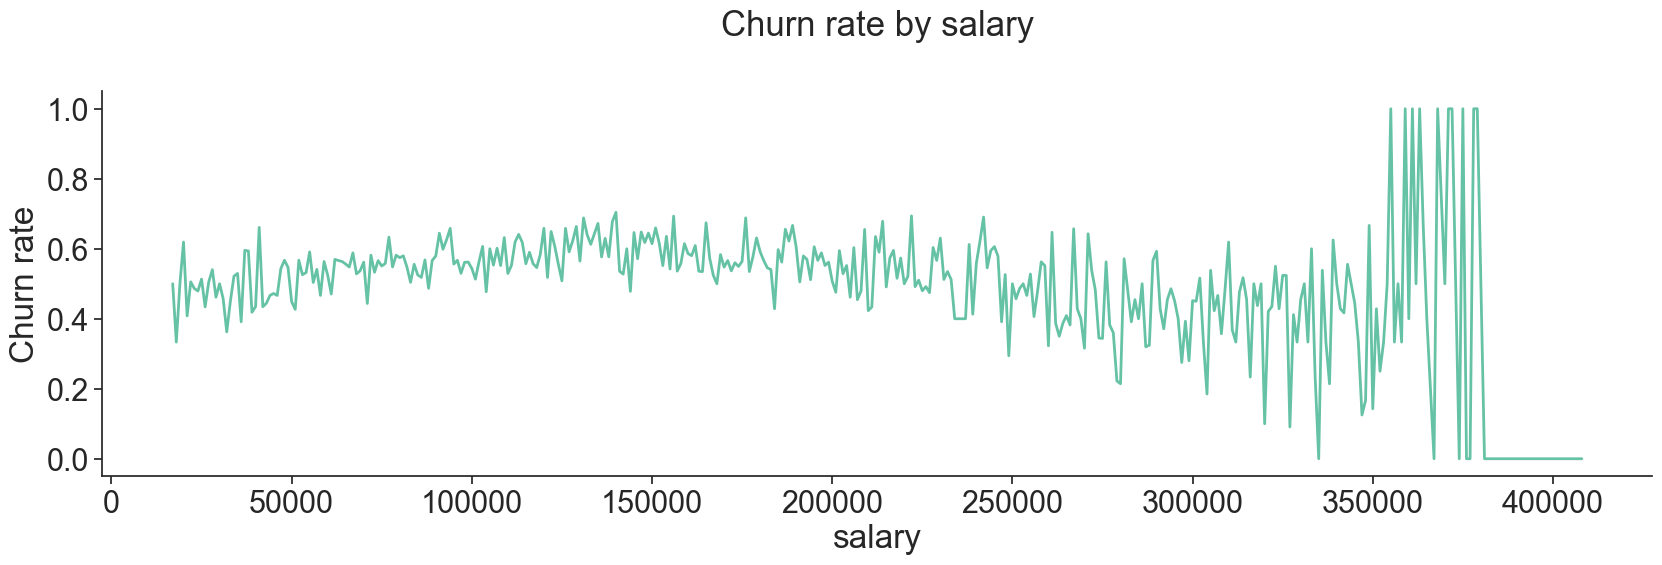

In [115]:
plot_conversion_rate_continuous(data, "salary")

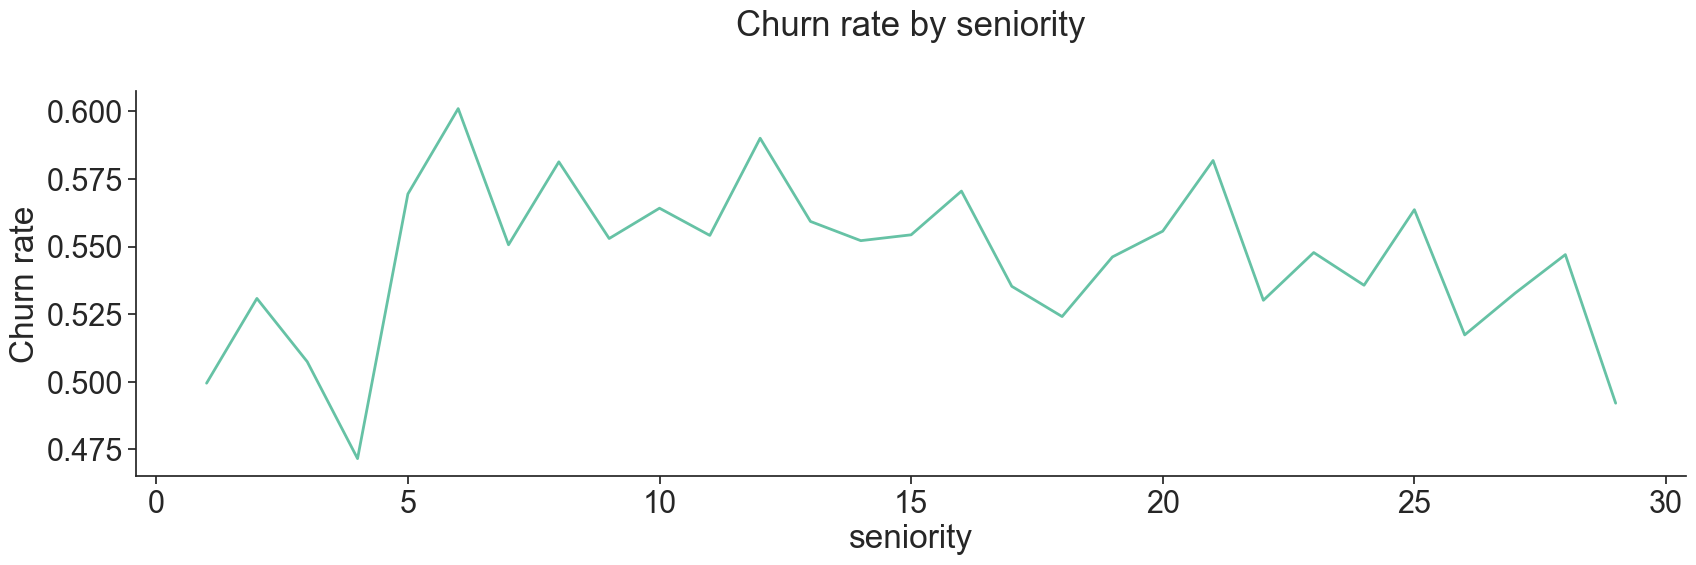

In [116]:
plot_conversion_rate_continuous(data, "seniority")

In [118]:
print(sum(data['churn'] == 1))
print(sum(data['churn'] == 0))

13508
11192


/var/folders/qk/znpvqtsn3jl5jf9q97fqz2cc0000gp/T/ipykernel_7417/2520878420.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target] = data[target].astype("category")


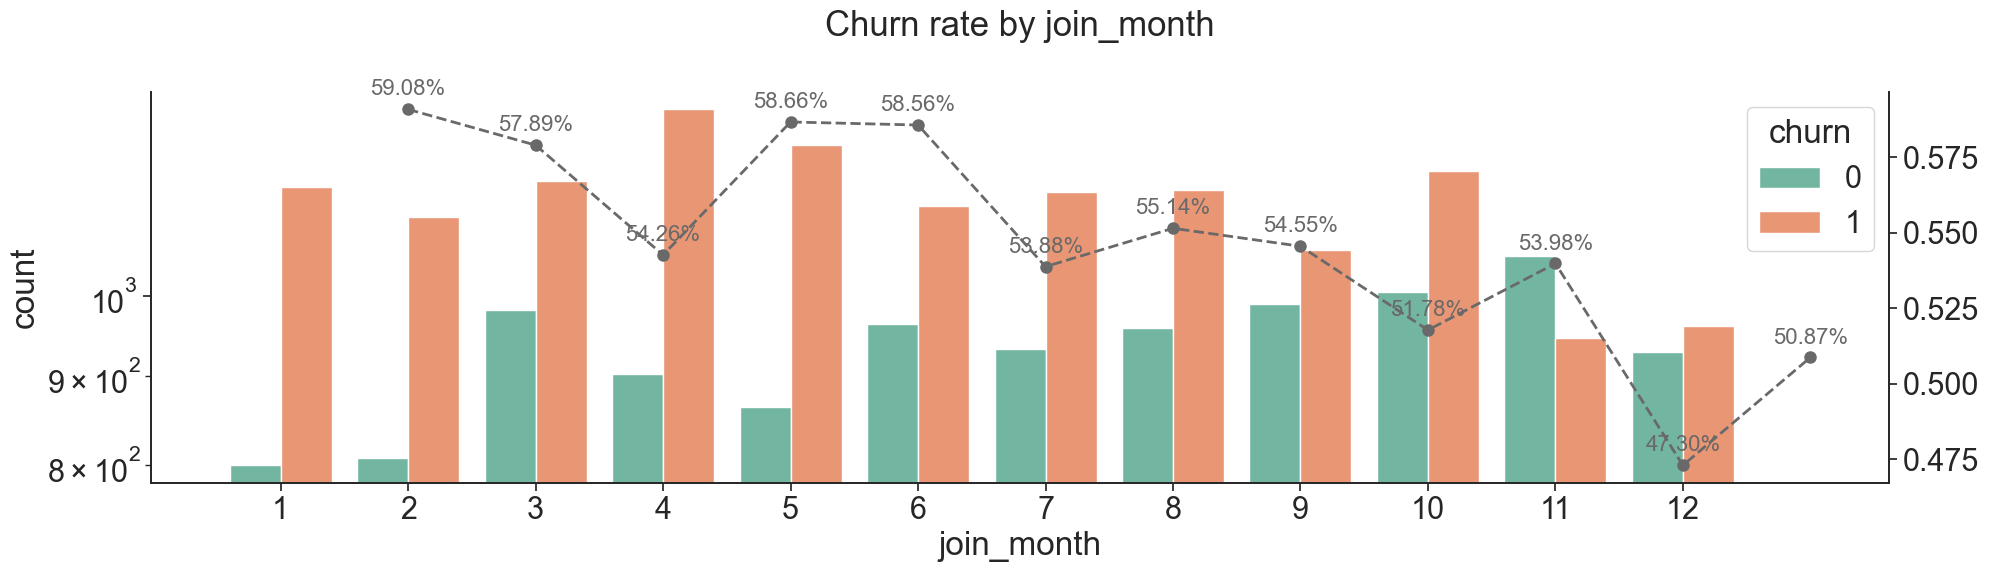

In [122]:
plot_conversion_rate_categorical(data, "join_month")

/var/folders/qk/znpvqtsn3jl5jf9q97fqz2cc0000gp/T/ipykernel_7417/2520878420.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target] = data[target].astype("category")


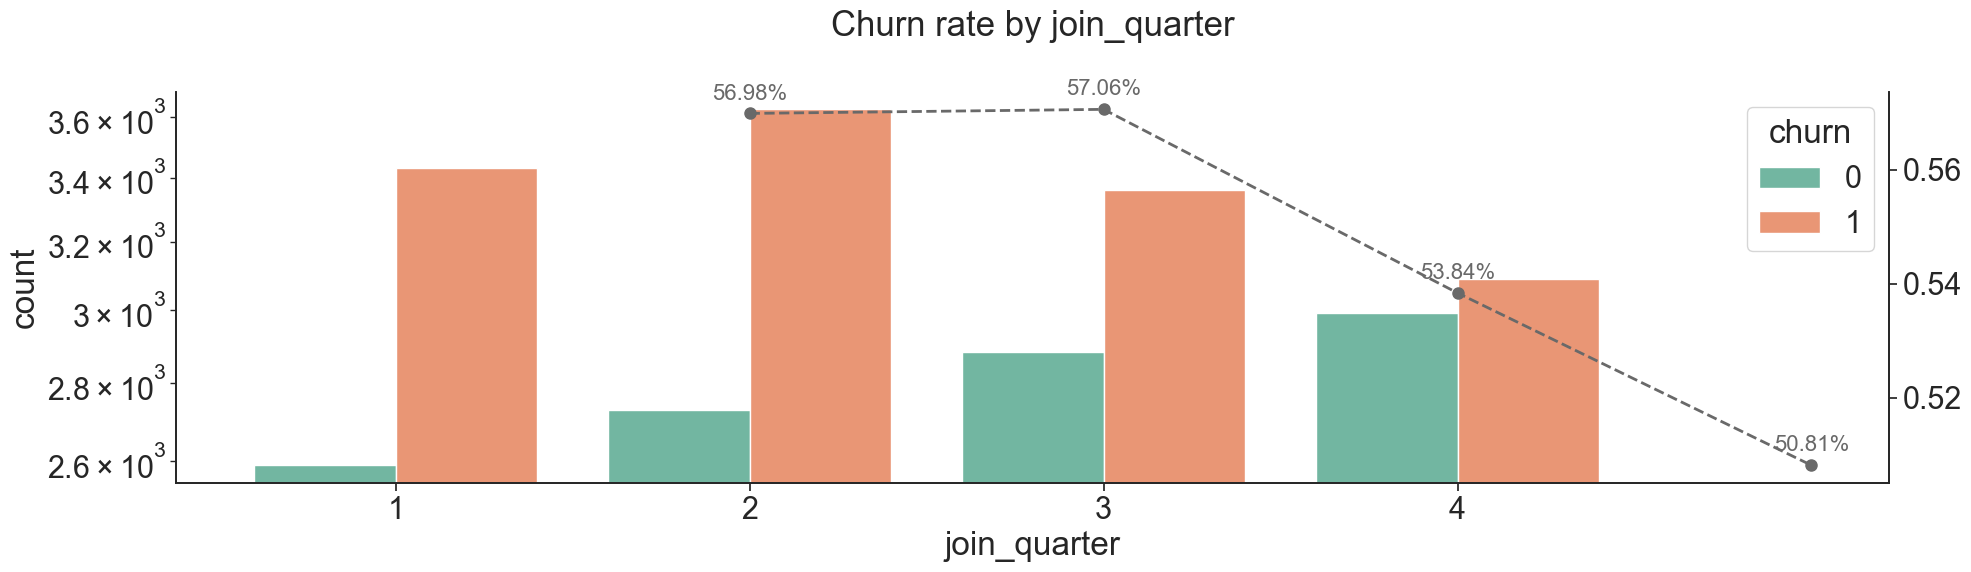

In [123]:
plot_conversion_rate_categorical(data, "join_quarter")

# Model

In [110]:
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,churn,duration,join_month,join_quarter
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,1,585,m3,q1
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,1,340,m4,q2
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,0,426,m10,q4
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1,389,m5,q2
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1,1040,m10,q4


In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [142]:
def get_dummies(df, cat_features = ["company_id", "dept", "join_month", "join_quarter"]):
    """Create dummy variables for categorical variables"""
    
    cat_features = [cat_col for cat_col in cat_features if cat_col in df.columns]
    
    new_df = df.drop(cat_features, axis=1)
    
    for cat_col in cat_features:
        
        dummies = pd.get_dummies(df[cat_col], drop_first=True, 
                                    prefix=sorted(df[cat_col].unique())[0])
        new_df = pd.concat([new_df, dummies], axis=1)
        
    return new_df

def feature_comparison_plot(features, values):

    plt.barh(features, values)
    plt.xlabel('Value')
    plt.ylabel('Feature')
    plt.show()

def model_train_test(model_name, select_features):
    
    X = data[select_features]
    y = data['churn']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    X_train = get_dummies(X_train)
    X_test = get_dummies(X_test)
    
    if model_name == "LR":
        model = LogisticRegression(penalty='none', max_iter=500)
    elif model_name == "RF":
        model = ensemble.RandomForestClassifier(n_estimators = 100)
        
    model.fit(X_train, y_train)
    y_prediction = model.predict(X_test)
    
    RF_roc_auc_value = roc_auc_score(y_test, y_prediction)
    
    print(classification_report(y_test, y_prediction))
    print(f"auc score = {RF_roc_auc_value:.4f}")
    
    # plot feature importances
    features_names = list(X_train.columns)
    
    if model_name == "LR":
        values = model.coef_.flatten()
    elif model_name == "RF":
        values = model.feature_importances_
    
    feature_comparison_plot(features_names, values)
    
    return model, y_prediction

              precision    recall  f1-score   support

           0       0.71      0.33      0.45      2238
           1       0.62      0.89      0.73      2703

    accuracy                           0.64      4941
   macro avg       0.67      0.61      0.59      4941
weighted avg       0.66      0.64      0.60      4941

auc score = 0.6100


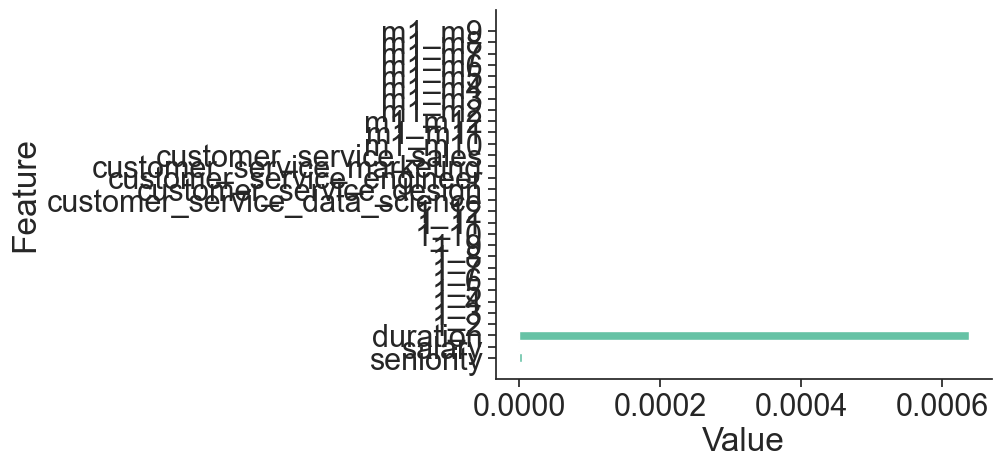

In [143]:
model, y_prediction = model_train_test("LR", ["company_id", "dept", "seniority", "salary", "duration", "join_month"])

              precision    recall  f1-score   support

           0       0.71      0.33      0.45      2238
           1       0.62      0.89      0.73      2703

    accuracy                           0.64      4941
   macro avg       0.67      0.61      0.59      4941
weighted avg       0.66      0.64      0.60      4941

auc score = 0.6100


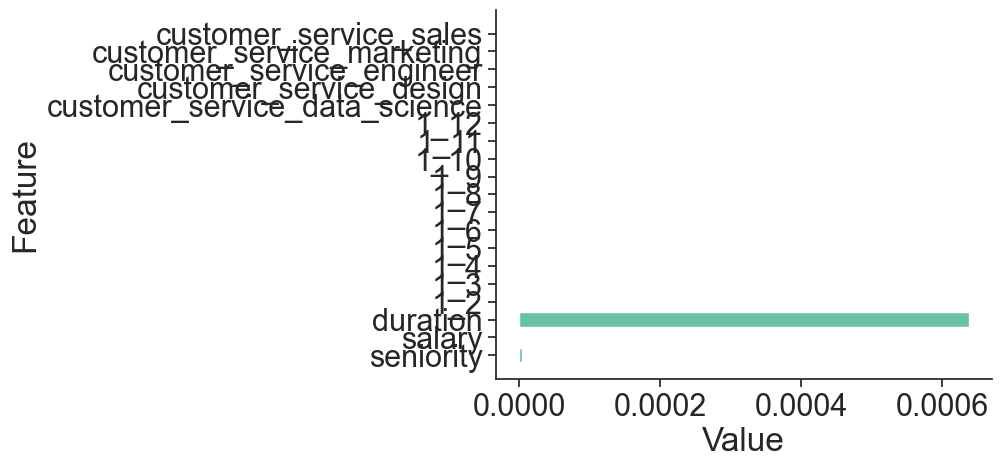

In [144]:
model, y_prediction = model_train_test("LR", ["company_id", "dept", "seniority", "salary", "duration"])

              precision    recall  f1-score   support

           0       0.71      0.33      0.45      2238
           1       0.62      0.89      0.73      2703

    accuracy                           0.64      4941
   macro avg       0.67      0.61      0.59      4941
weighted avg       0.66      0.64      0.60      4941

auc score = 0.6100


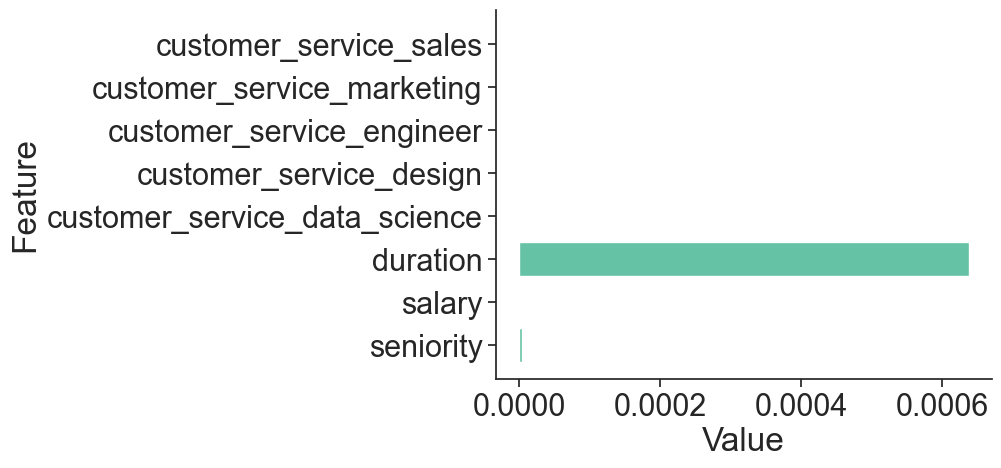

In [145]:
model, y_prediction = model_train_test("LR", ["dept", "seniority", "salary", "duration"])

              precision    recall  f1-score   support

           0       0.71      0.33      0.45      2238
           1       0.62      0.89      0.73      2703

    accuracy                           0.64      4941
   macro avg       0.67      0.61      0.59      4941
weighted avg       0.66      0.64      0.60      4941

auc score = 0.6100


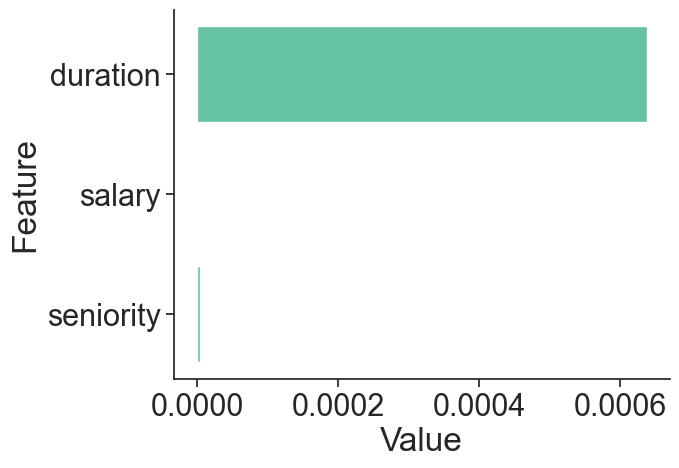

In [146]:
model, y_prediction = model_train_test("LR", ["seniority", "salary", "duration"])

              precision    recall  f1-score   support

           0       0.73      0.67      0.70      2238
           1       0.75      0.80      0.77      2703

    accuracy                           0.74      4941
   macro avg       0.74      0.73      0.74      4941
weighted avg       0.74      0.74      0.74      4941

auc score = 0.7340


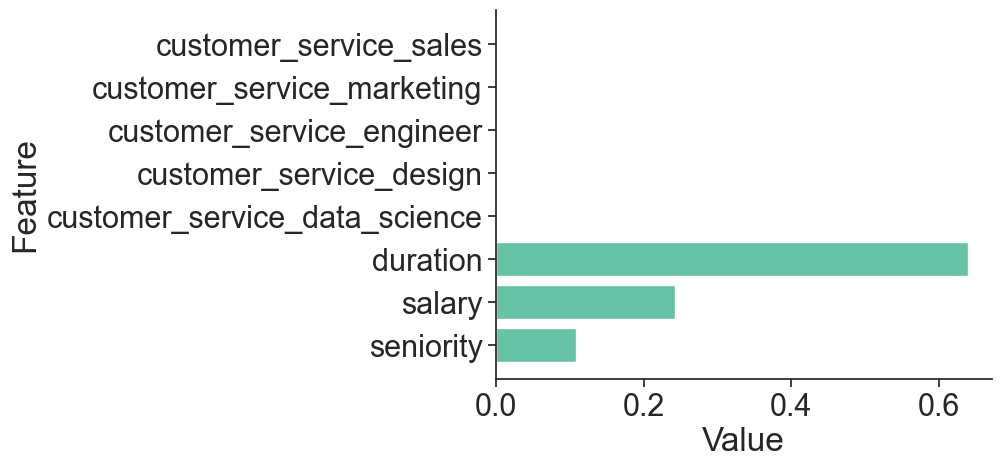

In [147]:
model, y_prediction = model_train_test("RF", ["dept", "seniority", "salary", "duration"])

              precision    recall  f1-score   support

           0       0.74      0.68      0.71      2238
           1       0.75      0.80      0.77      2703

    accuracy                           0.75      4941
   macro avg       0.74      0.74      0.74      4941
weighted avg       0.75      0.75      0.74      4941

auc score = 0.7400


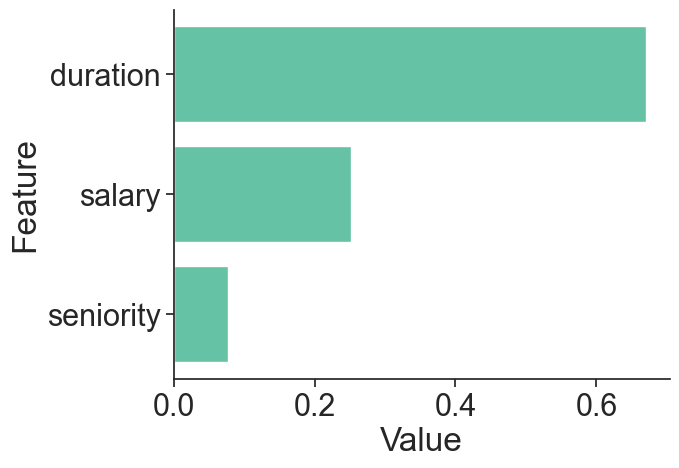

In [148]:
model, y_prediction = model_train_test("RF", ["seniority", "salary", "duration"])

              precision    recall  f1-score   support

           0       0.78      0.75      0.77      2238
           1       0.80      0.83      0.81      2703

    accuracy                           0.79      4941
   macro avg       0.79      0.79      0.79      4941
weighted avg       0.79      0.79      0.79      4941

auc score = 0.7903


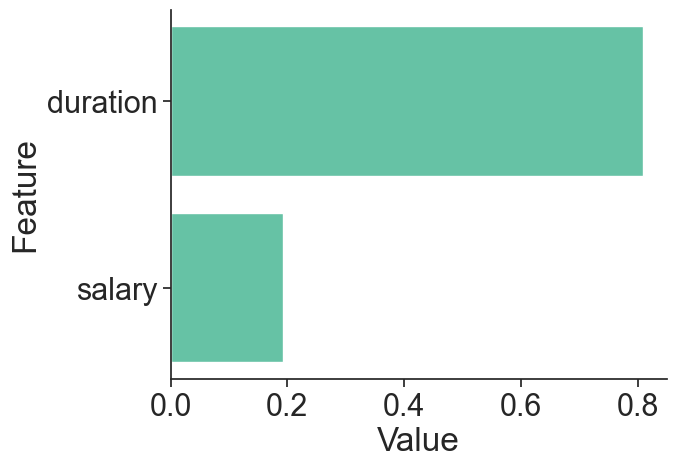

In [149]:
model, y_prediction = model_train_test("RF", ["salary", "duration"])